Bank renege
 0.0000 Customer00: Here I am
 0.0000 Customer00: Waited  0.000
 1.3796 Customer00: Finished
 5.4781 Customer01: Here I am
 5.4781 Customer01: Waited  0.000
 6.1168 Customer01: Finished
19.2951 Customer02: Here I am
19.2951 Customer02: Waited  0.000
26.8998 Customer02: Finished
40.7420 Customer03: Here I am
40.7420 Customer03: Waited  0.000
42.8754 Customer04: Here I am
42.9064 Customer03: Finished
42.9064 Customer04: Waited  0.031
48.4366 Customer04: Finished
###############################################################################
RESULTADOS OBTENIDOS
###############################################################################
Número de clientes que llegaron->5
Número de clientes que fueron atendidos en el banco->5
Número de clientes que abandonaron en el banco->0
Tiempo promedio de espera del cliente en la fila->0.00618937983266
Tiempo promedio del cliente en el banco->3.46971630867
Tamaño promedio de la fila->0.5
################################################

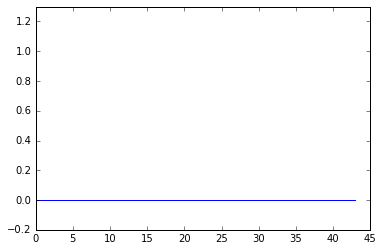

###############################################################################
Grafica de cantidad de clientes en el banco


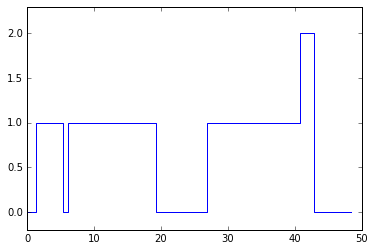

In [12]:
# -- coding: utf-8 --
import random
import simpy
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import math
%matplotlib inline 
RANDOM_SEED = 42
NEW_CUSTOMERS = 5  # Total number of customers
INTERVAL_CUSTOMERS = 12.0  # Generate new customers roughly every x seconds
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience
time_in_blank =9.0
#---------------
SEMILLA_INICIAL = 123456
NUM_CLIENTES = 0
NUM_CLIENTES_ATEN = 0
NUM_CLIENTES_ABAN = 0
TIEM_PROM_ESPERA_FILA = []
TIEM_PROM_CLIENTE_BANCO = []
TAM_FILA = 0
TAM_FILA_PROM = []
TIEM_FILA_PROM=[]
NUM_CLIENTES_BANCO = 0
NUM_CLIENTES_BANCO_PROM = []
TIEM_CLIENTES_BANCO_PROM = []

def borland(n):
    global SEMILLA_INICIAL
    x0 = SEMILLA_INICIAL
    a=22695477
    b=1
    m=2**32
    num = []
    for i in range(0,n):
        xi = ((a*x0)+(b))%m
        SEMILLA_INICIAL = xi
        num.append(float(xi)/float(m))
        x0=xi
    return num

def gen_exp(l,n):
    x = borland(n)
    inv = []
    for i in x:
        inv.append(float(-(np.log(1-i)))/float((l)))
    return inv[0]

def gen_uni(a,b,n):
    x = borland(n)
    inv = []
    for i in x:
        inv.append(a+i*(b-a))
    return inv[0]

def source(env, number, interval, counter):
    global NUM_CLIENTES,TAM_FILA, time_in_blank
    """Source generates customers randomly"""
    for i in range(number):
        NUM_CLIENTES+=1
        c = customer(env, 'Customer%02d' % i, counter, time_in_blank)
        env.process(c)
        t = gen_exp(1.0/interval,1)
        yield env.timeout(t)


def customer(env, name, counter, time_in_bank):
    global NUM_CLIENTES_ATEN,NUM_CLIENTES_ABAN,TIEM_PROM_ESPERA_FILA,TIEM_PROM_CLIENTE_BANCO,TAM_FILA
    global TIEM_FILA_PROM,NUM_CLIENTES_BANCO,NUM_CLIENTES_BANCO_PROM,TIEM_CLIENTES_BANCO_PROM

    """Customer arrives, is served and leaves."""
    arrive = env.now
    #aumenta el tamaño de la fila
    TAM_FILA+=1
    NUM_CLIENTES_BANCO+=1
    #guardamos el tamaño de la fila
    TAM_FILA_PROM.append(TAM_FILA)
    NUM_CLIENTES_BANCO_PROM.append(NUM_CLIENTES_BANCO)
    #guardamos el tiempo del nuevo tamaño de la fila
    TIEM_FILA_PROM.append(arrive)
    TIEM_CLIENTES_BANCO_PROM.append(arrive)
    
    print('%7.4f %s: Here I am' % (arrive, name))

    with counter.request() as req:
        patience = gen_uni(MIN_PATIENCE, MAX_PATIENCE,1)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)
        wait = env.now - arrive
        if req in results:
            #disminuye el tamaño de la fila
            TAM_FILA-=1
            #guardamos el tamaño de la fila y el tiempo actual
            if TAM_FILA == 0:
                if TIEM_FILA_PROM[len(TIEM_FILA_PROM)-1] == env.now:
                    TAM_FILA_PROM.pop()
                    TIEM_FILA_PROM.pop()
                else:
                    TIEM_FILA_PROM.append(env.now)
                    TAM_FILA_PROM.append(TAM_FILA)
            else:
                TIEM_FILA_PROM.append(env.now)
                TAM_FILA_PROM.append(TAM_FILA)
            
            NUM_CLIENTES_ATEN+=1
            TIEM_PROM_ESPERA_FILA.append(wait)
            # We got to the counter
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
            
            
            tib = gen_exp(1.0/time_in_bank,1)
            TIEM_PROM_CLIENTE_BANCO.append(wait+tib)
            yield env.timeout(tib)
            print('%7.4f %s: Finished' % (env.now, name))
            
            
            NUM_CLIENTES_BANCO-=1
            NUM_CLIENTES_BANCO_PROM.append(NUM_CLIENTES_BANCO)
            TIEM_CLIENTES_BANCO_PROM.append(env.now)
            
        else:
            #disminuye el tamaño de la fila
            TAM_FILA-=1
            #guardamos el tamaño de la fila
            TAM_FILA_PROM.append(TAM_FILA)
            #guardamos el tiempo del nuevo tamaño de la fila
            TIEM_FILA_PROM.append(env.now)
            
            NUM_CLIENTES_ABAN+=1
            TIEM_PROM_CLIENTE_BANCO.append(wait)
            # We reneged
            print('%7.4f %s: RENEGED after %6.3f' % (env.now, name, wait))
            NUM_CLIENTES_BANCO-=1
            NUM_CLIENTES_BANCO_PROM.append(NUM_CLIENTES_BANCO)
            TIEM_CLIENTES_BANCO_PROM.append(env.now)
            
def graficar_tiempo_fila():
    global TAM_FILA_PROM,TIEM_FILA_PROM
    x=[]
    f=[]
    for i in range(0,len(TIEM_FILA_PROM)):    
        if len(x) == 0:
            x_aux = np.arange(0.0,TIEM_FILA_PROM[i],0.1)
            for y in x_aux:
                x.append(y)
                f.append(0)
        else:
            x_aux = np.arange(x[len(x)-1],TIEM_FILA_PROM[i],0.1)
            for y in x_aux:
                x.append(y)
                f.append(TAM_FILA_PROM[i])
    
    plt.plot(x,f)
    plt.ylim(-0.2, max(TAM_FILA_PROM)+0.3)
    plt.show()
    
def graficar_tiempo_clientes():
    global NUM_CLIENTES_BANCO_PROM, TIEM_CLIENTES_BANCO_PROM
    x=[]
    f=[]
    for i in range(0,len(TIEM_CLIENTES_BANCO_PROM)):    
        if len(x) == 0:
            x_aux = np.arange(0.0,TIEM_CLIENTES_BANCO_PROM[i],0.1)
            for y in x_aux:
                x.append(y)
                f.append(0)
        else:
            x_aux = np.arange(x[len(x)-1],TIEM_CLIENTES_BANCO_PROM[i],0.1)
            for y in x_aux:
                x.append(y)
                f.append(NUM_CLIENTES_BANCO_PROM[i])
    
    plt.plot(x,f)
    plt.ylim(-0.2, max(NUM_CLIENTES_BANCO_PROM)+0.3)
    plt.show()
    
# Setup and start the simulation
print('Bank renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Start processes and run
counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()

print ("###############################################################################")
print ("RESULTADOS OBTENIDOS")
print ("###############################################################################")
print ("Número de clientes que llegaron->")+str(NUM_CLIENTES)
print ("Número de clientes que fueron atendidos en el banco->")+str(NUM_CLIENTES_ATEN)
print ("Número de clientes que abandonaron en el banco->")+str(NUM_CLIENTES_ABAN)
prom = 0
for i in TIEM_PROM_ESPERA_FILA:
    prom+=i
print ("Tiempo promedio de espera del cliente en la fila->")+str(float(prom)/float(len(TIEM_PROM_ESPERA_FILA)))
prom = 0
for i in TIEM_PROM_CLIENTE_BANCO:
    prom+=i
print ("Tiempo promedio del cliente en el banco->")+str(float(prom)/float(len(TIEM_PROM_CLIENTE_BANCO)))
prom = 0
for i in TAM_FILA_PROM:
    prom+=i
print ("Tamaño promedio de la fila->")+str(float(prom)/float(len(TAM_FILA_PROM)))  

print ("###############################################################################")
print ("Grafica del tamaño de la fila con respecto al tiempo")
graficar_tiempo_fila()
print ("###############################################################################")
print ("Grafica de cantidad de clientes en el banco")
graficar_tiempo_clientes()